In [41]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms 

from PIL import Image
from scipy.ndimage import shift
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import numpy as np

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score

import email
import email.policy
import os

In [18]:
# GPU support available
if torch.cuda.is_available():
    allocated_memory_bytes = torch.cuda.mem_get_info()[1]
    allocated_memory_gb = allocated_memory_bytes / (1024**3)
    print(torch.cuda.get_device_name(0))
    print(f"Currently allocated GPU memory: {allocated_memory_gb:.2f} GB")
else:
    print("CUDA is not available.")

NVIDIA GeForce RTX 5060 Ti
Currently allocated GPU memory: 15.48 GB


In [2]:
mnist_train_set = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test_set = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [3]:
len(mnist_train_set)

60000

In [4]:
type(mnist_train_set)

torchvision.datasets.mnist.MNIST

In [5]:
mnist_train_set[0], mnist_train_set[1]

((<PIL.Image.Image image mode=L size=28x28>, 5),
 (<PIL.Image.Image image mode=L size=28x28>, 0))

In [6]:
first_img, first_target = mnist_train_set[0]

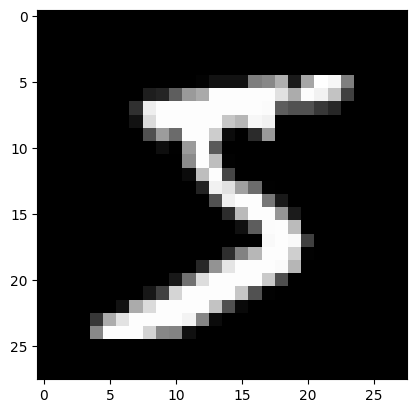

In [7]:
plt.imshow(first_img, cmap='gray')
plt.show()

In [8]:
first_target

5

### SGD Classifier for 5 or not 5

In [9]:
# picking a random image
i = np.random.randint(len(mnist_train_set))
print(i)

21316


In [10]:
x_train = np.array([
    np.array(img).reshape(-1) for img, label in mnist_train_set])
x_test = np.array([
    np.array(img).reshape(-1) for img, label in mnist_test_set])

y_train = np.array([label for _, label in mnist_train_set])
y_test = np.array([label for _, label in mnist_test_set])

y_train_5 = np.array([label == 5 for _, label in mnist_train_set])
y_test_5 = np.array([label == 5 for _, label in mnist_test_set])
print(x_train.shape, y_train_5.shape, x_test.shape, y_test_5.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [11]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [12]:
# some random digit
rndm_dgt, its_label = mnist_train_set[i]
y_pred = sgd_clf.predict(np.array([np.array(rndm_dgt).reshape(-1)]))

In [13]:
y_pred

array([False])

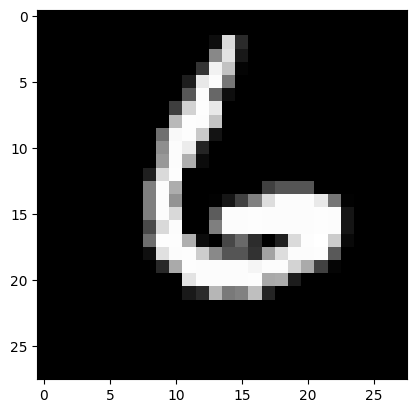

In [14]:
plt.imshow(rndm_dgt, cmap='gray')
plt.show()

In [15]:
# metrics
scre = cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")
print(scre)
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

[0.95035 0.96035 0.9604 ]


## Note:
- This is a dumb classifier as it only, showcases not 5. Provided we have data which is skewed, accuracy isn't a good metrics to be happy with.


In [16]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [20]:
# decision function
y_scores = sgd_clf.decision_function(np.array([np.array(rndm_dgt).reshape(-1)]))
y_scores

array([-5407.69362076])

In [21]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')

In [22]:
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

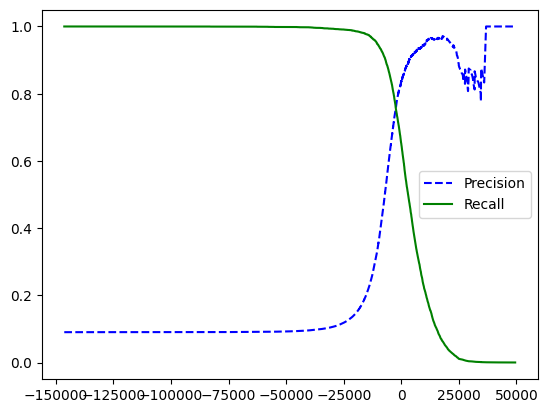

In [23]:
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.legend()
plt.show()

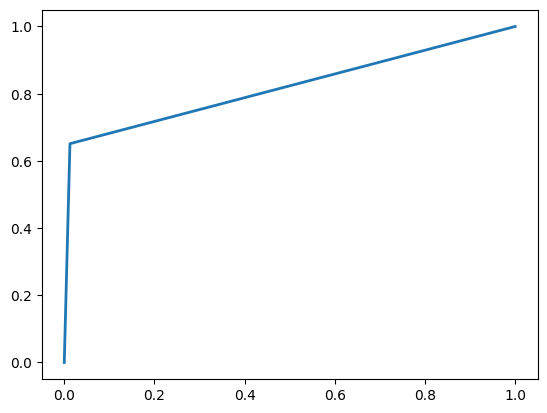

In [24]:
# ROC Curve
fpr, tpr, thresh = roc_curve(y_train_5, y_train_pred)

plt.plot(fpr, tpr, linewidth=2)
plt.show()

In [25]:
## random forest classifier
rndm_frst = RandomForestClassifier(random_state=42)
y_frst_probas = cross_val_predict(rndm_frst, x_train, y_train_5, cv=3, method='predict_proba')


In [26]:
y_scores_frst = y_frst_probas[:, 1]
fpr_frst, tpr_frst, thresh_frst = roc_curve(y_train_5, y_scores_frst)

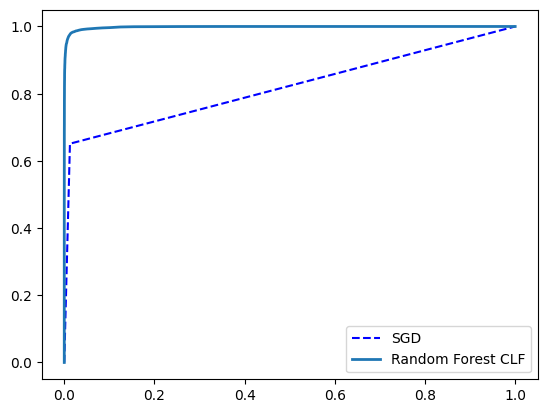

In [27]:
plt.plot(fpr, tpr, 'b--', label="SGD")
plt.plot(fpr_frst, tpr_frst, linewidth=2, label="Random Forest CLF")
plt.legend()
plt.show()

In [28]:
# roc_auc score
roc_auc_score(y_train_5, y_scores_frst)

0.9983436731328145

In [29]:
y_train.shape, y_scores_frst.shape

((60000,), (60000,))

In [30]:
# convert probabilities to classes
y_pred_frst = (y_scores_frst >= 0.5)

In [31]:
precision_score(y_train_5, y_pred_frst)

0.9897468089558485

In [32]:
recall_score(y_train_5, y_pred_frst)

0.8725327430363402

### Multi class classifier

In [33]:
scaler = StandardScaler()
rndm_frst_multi_clf = RandomForestClassifier(random_state=42)
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(rndm_frst_multi_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.96445, 0.96255, 0.96645])

In [34]:
y_train_pred_multi = cross_val_predict(rndm_frst_multi_clf, x_train_scaled, y_train, cv=3)
conf_matrx = confusion_matrix(y_train, y_train_pred_multi)
conf_matrx

array([[5840,    1,    8,    2,    4,    9,   20,    1,   35,    3],
       [   1, 6634,   43,   12,   13,    5,    6,   13,   12,    3],
       [  26,   12, 5749,   29,   32,    5,   20,   37,   42,    6],
       [   7,    7,   93, 5809,    3,   63,    7,   49,   61,   32],
       [  12,   13,   14,    1, 5643,    0,   29,   14,   17,   99],
       [  20,    9,    9,   65,   13, 5195,   53,    6,   32,   19],
       [  25,   11,    5,    0,   12,   45, 5805,    0,   15,    0],
       [   4,   24,   58,    6,   37,    1,    0, 6037,   11,   87],
       [   9,   35,   44,   53,   26,   52,   27,    5, 5524,   76],
       [  21,   10,   13,   76,   75,   15,    3,   58,   45, 5633]])

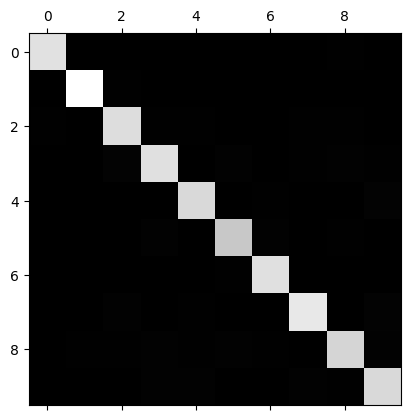

In [35]:
plt.matshow(conf_matrx, cmap=plt.cm.gray)

## Exercise

### 1. Build Classifier for MNIST and acheve over 97% accuracy

In [36]:
# we already have x_train, y_train, x_test and y_test
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# lets try with KNN and XGBoost

knn = KNeighborsClassifier()
cross_val_score_knn = cross_val_score(knn, x_train, y_train, scoring="accuracy", cv=3)
print("Mean Cross val score for KNN: {}".format(cross_val_score_knn.mean()))

xgb_clf = XGBClassifier()
cross_val_score_xgb = cross_val_score(xgb_clf, x_train, y_train, scoring="accuracy", cv=3)
print("Mean Cross val score for XGB_clf: {}".format(cross_val_score_xgb.mean()))

(60000, 784) (60000,) (10000, 784) (10000,)
Mean Cross val score for KNN: 0.9674166666666667
Mean Cross val score for XGB_clf: 0.9731166666666667


### 2. MNIST data augmentation: image left, right, up or down shift by one pixel:

- ~~Ok. To perfrom data augmentation, one must apply it before the split right, so there is randomness and more data to learn from for the model. Hence will now split the data from torch MNIST loading directly~~
- That was a noob mistake: Data augmentation should be applied only on the training dataset, keep test dataset seperate

In [37]:
def image_shifting(x_train):
    '''
    Input: Image (torch.tensor())
    Process: perform 1 pixel shift up, down, left and right 
    Output: images with four shift: up, down, left, right'''
    # convert x_train, y_train back into 28x28 pixels
    if isinstance(x_train, np.ndarray):
        x_train_imgs = x_train.reshape(-1, 28, 28)
    else:
        x_train_imgs = x_train.numpy().reshape(-1, 28, 28)
    
    def shift_imgs(images, shift_xy):
        return np.array([shift(img, shift_xy, cval=0) for img in images])
    
    up = shift_imgs(x_train_imgs, (-1,0))
    down = shift_imgs(x_train_imgs, (1,0))
    right = shift_imgs(x_train_imgs, (0,-1))
    left = shift_imgs(x_train_imgs, (0,1))
    return up, down, right, left

In [38]:
# lets add this to the x_train data
up, down, right, left = image_shifting(x_train)
print(up.shape)

(60000, 28, 28)


In [39]:
x_aug = np.concatenate([x_train.reshape(-1, 28, 28), up, down, right, left])
x_aug = x_aug.reshape(-1, 784)

y_aug = np.tile(y_train, 5)
print(x_aug.shape, y_aug.shape)

(300000, 784) (300000,)


In [40]:
# applying aug on our classifiers
knn = KNeighborsClassifier(n_jobs=-1) # will try with cuml.neighbors
cross_val_score_knn = cross_val_score(knn, x_aug, y_aug, scoring="accuracy", cv=3)
print("Mean Cross val score for KNN: {:.4f}".format(cross_val_score_knn.mean()))

Mean Cross val score for KNN: 0.9726


In [41]:
xgb_clf = XGBClassifier(device='cuda')
cross_val_score_xgb = cross_val_score(xgb_clf, x_aug, y_aug, scoring="accuracy", cv=3)
print("Mean Cross val score for XGB_clf: {:.4f}".format(cross_val_score_xgb.mean()))

/home/rishi/.pyenv/versions/3.10.19/envs/py3_10/lib/python3.10/site-packages/xgboost/core.py:774: UserWarning: [18:34:53] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Mean Cross val score for XGB_clf: 0.9778


In [42]:
# prediction on test set and checking accuracy


### 3. Build a spam classifier
- Using: https://spamassassin.apache.org/old/publiccorpus/

In [32]:
HAM_DIR = os.listdir('../../datasets/spam_2')[:2]
SPAM_DIR = os.listdir('../../datasets/easy_ham_2')[:2]
print(HAM_DIR, SPAM_DIR)

['00001.317e78fa8ee2f54cd4890fdc09ba8176', '00002.9438920e9a55591b18e60d1ed37d992b'] ['00001.1a31cc283af0060967a233d26548a6ce', '00002.5a587ae61666c5aa097c8e866aedcc59']


In [51]:
# using mailbox to read
HAM_PATH = '../../datasets/easy_ham_2'
SPAM_PATH = '../../datasets/spam_2'

def load_email(HAM_PATH):
    mails = []    
    for file in os.listdir(HAM_PATH):
        file_path = os.path.join(HAM_PATH, file)
        with open(file_path, 'rb') as f:
            mails.append(email.parser.BytesParser(policy=email.policy.default).parse(f))
    return mails

ham_emails = load_email(HAM_PATH)
spam_emails = load_email(SPAM_PATH)

In [52]:
len(ham_emails), len(spam_emails)

(1401, 1397)

In [65]:
def get_email_body(msg):
    """Extract plain text or HTML body from an email message."""
    body = ""
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))
            
            if content_type in ["text/plain", "text/html"] and "attachment" not in content_disposition:
                try:
                    content = part.get_payload(decode=True).decode(errors="ignore")
                    body += content
                except Exception:
                    pass
    else:
        body = msg.get_payload(decode=True).decode(errors="ignore")
    return body


In [66]:
print(get_email_body(ham_emails[2]).strip())


> From:  Robert Elz <kre@munnari.OZ.AU>
> Date:  Wed, 21 Aug 2002 15:01:07 +0700
>
>     Date:        Tue, 20 Aug 2002 22:51:52 -0400
>     From:        Valdis.Kletnieks@vt.edu
>     Message-ID:  <200208210251.g7L2pqKb001805@turing-police.cc.vt.edu>
> 
>   | Ever tried to get MH to *not* have a 'pseq' sequence?
> 
> Hmm - I've been using MH for a long time (since well before there were
> sequences) and I don't think I've ever seen a "pseq" ...
> 
> I'm guessing that that's the sequence that you have "pick" create
> As I recall it, it has no default sequence name, so the sequence names
> that people use will tend to vary from person to person won't they
> (except as MH configurations move around institutions by osmosis).
> 
> I've always used "sel" for that purpose.
> 
> I kind of doubt that any pre built-in sequence name is going to be
> very general.   Even "unseen" can be changed (fortunately that one
> is easy to find in the MH profile - though whether exmh does that,
> os just uses

In [68]:
print(get_email_body(spam_emails[6]).strip())


<html>
           <DIV>&nbsp;</DIV><FONT size=2 PTSIZE="10">
      <TABLE 
      style="BORDER-RIGHT: #006600 12px double; PADDING-RIGHT: 4px; BORDER-TOP: #006600 12px double; PADDING-LEFT: 4px; PADDING-BOTTOM: 1px; BORDER-LEFT: #006600 12px double; PADDING-TOP: 1px; BORDER-BOTTOM: #006600 12px double; BORDER-COLLAPSE: collapse" 
      borderColor=#111111 height=338 cellSpacing=0 borderColorDark=#ffffff 
      cellPadding=0 width=539 borderColorLight=#ffffff border=0>
        <TBODY>
        <TR>
          <TD width=4 height=423>&nbsp;</TD>
          <TD 
          style="BORDER-RIGHT: 0px solid; BORDER-TOP: 0px solid; BORDER-LEFT: 0px solid; BORDER-BOTTOM: 0px solid" 
          vAlign=top align=left width=535 height=423>
            <TABLE style="BORDER-COLLAPSE: collapse" borderColor=#111111 
            cellSpacing=0 cellPadding=4 width="95%" bgColor=#ffffff border=0>
              <TBODY>
              <TR>
                <TD vAlign=top align=right height=424>
                  <T